### <font style="color:blue">Project 4: Kaggle Competition - Semantic Segmentation</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>1.1. Dataset Class</h3></td> <td><h3>7</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>1.2. Visualize dataset</h3></td> <td><h3>3</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>2. Evaluation Metrics</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>3. Model</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>4.1. Train</h3></td> <td><h3>7</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>4.2. Inference</h3></td> <td><h3>3</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>5. Prepare Submission CSV</h3></td><td><h3>10</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>6. Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>

---

**In this project, you have participated in the Kaggle competition, and also submit the notebook and othe code in the course lab.**

**This Kaggle competition is a semantic segmentation challenge.**

<h2>Dataset Description </h2>
<p>The dataset consists of 3,269 images in 12 classes (including background). All images were taken from drones in a variety of scales. Samples are shown below:
<img src="https://github.com/ishann/aeroscapes/blob/master/assets/data_montage.png?raw=true" width="800" height="800">
<p>The data was splitted into public train set and private test set which is used for evaluation of submissions. You can split public subset into train and validation sets yourself.
Images are named with a unique <code>ImageId</code>. </p>
<p> You should segment and classify the images in the test set.</p>
<p>The dataset consists of landscape images taken from drones in a variety of scales.</p>

**The notebook is divided into sections. You have to write code, as mention in the section.  For other helper functions, you can write `.py` files and import them in the notebook. You have to submit the notebook along with `.py` files. Your submitted code must be runnable without any bug.**

# <font style="color:green">1. Data Exploration</font>

In this section, you have to write your custom dataset class and visualize a few images (max five images) and its mask.

## <font style="color:green">1.1. Dataset Class [7 Points]</font>

**In this sub-section, write your custom dataset class.**


**Note that there are not separate validation data, so you will have to create your validation set by dividing train data into train and validation data. Usually, in practice, we do `80:20` ratio for train and validation, respectively.** 

**for example:**

```
class SemSegDataset(Dataset):
    """ Generic Dataset class for semantic segmentation datasets.

        Arguments:
            data_path (string): Path to the dataset folder.
            images_folder (string): Name of the folder containing the images (related to the data_path).
            masks_folder (string): Name of the folder containing the masks (related to the data_path).
            csv_path (string): train or test csv file name
            image_ids (list): List of images.
            train_val_test (string): 'train', 'val' or 'test'
            transforms (callable, optional): A function/transform that inputs a sample
                and returns its transformed version.
            class_names (list, optional): Names of the classes.
            

        Dataset folder structure:
            Folder containing the dataset should look like:
            - data_path
            -- images_folder
            -- masks_folder

            Names of images in the images_folder and masks_folder should be the same for same samples.
    """
```

In [1]:
import os
import shutil
import random
import math
import tqdm
import csv

import cv2
import numpy as np
import matplotlib.pyplot as plt

from operator import itemgetter

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.models as models

from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import MultiStepLR

from albumentations import Compose, Normalize, RandomCrop, HorizontalFlip, ShiftScaleRotate, HueSaturationValue
from albumentations.pytorch import ToTensorV2

from trainer import Trainer, hooks

from trainer.utils import draw_semantic_segmentation_samples, patch_configs, setup_system, draw_semantic_segmentation_batch
from trainer.base_metric import BaseMetric
from trainer.configuration import SystemConfig, DatasetConfig, TrainerConfig, OptimizerConfig, DataloaderConfig
from trainer.matplotlib_visualizer import MatplotlibVisualizer

from segmentation.SemSegDataset import SemSegDataset
from segmentation.ConfusionMatrix import ConfusionMatrix
from segmentation.ConfusionMatrixBasedMetric import ConfusionMatrixBasedMetric
from segmentation.DiceCoefficient import DiceCoefficient
from segmentation.DecoderBlock import DecoderBlock
from segmentation.LinkNet_Model import LinkNet
from segmentation.IntersectionOverUnion import IntersectionOverUnion
from segmentation.Experiment import Experiment

In [2]:
# this cell contains code to reorganise the provided test and train images 
# into the expected format for the SemSegDataset class below
# it also divides the training data into training and validation sets

# Set this to true to actually do the file copying/organising (takes a few minutes)
ORGANISE_IMAGES = False
TRAIN_RATIO = 0.8                     # proportion of images used for training

INPUT_IMAGE_TYPE = "jpg"              # file extension for provided images
INPUT_MASK_TYPE = "png"               # file extension for provided image masks (segmentation ground truth)

# location of provided images, masks and csv files
# INPUT_DATA_ROOT = os.path.abspath(os.path.join(os.sep, 'kaggle', 'input', "opencv-pytorch-course-segmentation"))
INPUT_DATA_ROOT = os.path.abspath(os.path.join(os.sep, os.getcwd(), 'data'))

TEST_CSV = os.path.join(INPUT_DATA_ROOT, "test.csv")
TRAIN_CSV = os.path.join(INPUT_DATA_ROOT, "train.csv")
INPUT_IMAGE_PATH = os.path.join(INPUT_DATA_ROOT, "imgs", "imgs")    # images are in imgs/imgs/... 
INPUT_MASK_PATH = os.path.join(INPUT_DATA_ROOT, "masks", "masks")   # masks are in masks/masks/...

# writable location where files can be organised freely
# OUTPUT_DATA_ROOT = os.path.abspath(os.path.join(os.sep, 'data_organised'))
OUTPUT_DATA_ROOT = os.path.abspath(os.path.join(os.sep, os.getcwd(), 'data_organised'))

# putting these in a dictionary structure so they can be iterated through below
# and also referenced individually later
OUTPUT_FOLDERS = {
    "test_data_path": os.path.join(OUTPUT_DATA_ROOT, "test"), 
    "train_data_path": os.path.join(OUTPUT_DATA_ROOT, "train"), 
    "validation_data_path": os.path.join(OUTPUT_DATA_ROOT, "val")
}
OUTPUT_SUBFOLDERS = {
    "output_image_path": "images", 
    "output_mask_path": "masks"
}

if ORGANISE_IMAGES:
    # build directory structure. delete any that already exist
    for folder in OUTPUT_FOLDERS.values():
        for sub in OUTPUT_SUBFOLDERS.values():
            if os.path.exists(os.path.join(folder, sub)):
                shutil.rmtree(folder)
            os.makedirs(os.path.join(folder, sub))

    # copy test images (according to test.csv) into the test image folder 
    dest_dir_test_img = os.path.join(OUTPUT_FOLDERS['test_data_path'], OUTPUT_SUBFOLDERS['output_image_path'])
    with open(TEST_CSV, "r") as f:
        filename = f.readline()
        count_test = 0
        while filename:
            filename = f.readline()
            image_path = os.path.join(INPUT_IMAGE_PATH, filename.strip() + "." + INPUT_IMAGE_TYPE)
            if os.path.exists(image_path):
                shutil.copy(image_path, dest_dir_test_img)
                count_test += 1
    print("{} files copied to {}".format(count_test, dest_dir_test_img))

    # copy training images (according to train.csv) and masks into train and val folders 
    # split images randomly according to train_ratio
    dest_dir_train_img = os.path.join(OUTPUT_FOLDERS['train_data_path'], OUTPUT_SUBFOLDERS['output_image_path'])
    dest_dir_train_mask = os.path.join(OUTPUT_FOLDERS['train_data_path'], OUTPUT_SUBFOLDERS['output_mask_path'])
    dest_dir_val_img = os.path.join(OUTPUT_FOLDERS['validation_data_path'], OUTPUT_SUBFOLDERS['output_image_path'])
    dest_dir_val_mask = os.path.join(OUTPUT_FOLDERS['validation_data_path'], OUTPUT_SUBFOLDERS['output_mask_path'])
    with open(TRAIN_CSV, "r") as f:
        filename = f.readline()
        count_val = 0
        count_train = 0
        while filename:
            filename = f.readline()
            image_path = os.path.join(INPUT_IMAGE_PATH, filename.strip() + "." + INPUT_IMAGE_TYPE)
            mask_path = os.path.join(INPUT_MASK_PATH, filename.strip() + "." + INPUT_MASK_TYPE)
            if os.path.exists(image_path) and os.path.exists(mask_path):
                if random.random() < TRAIN_RATIO:
                    shutil.copy(image_path, dest_dir_train_img)
                    shutil.copy(mask_path, dest_dir_train_mask)
                    count_train += 1
                else:
                    shutil.copy(image_path, dest_dir_val_img)
                    shutil.copy(mask_path, dest_dir_val_mask)
                    count_val += 1
    print("{} files copied to {}".format(count_train, dest_dir_train_img))
    print("{} files copied to {}".format(count_val, dest_dir_val_img))

## <font style="color:green">1.2. Visualize dataset [3 Points]</font>

**In this sub-section,  you have to plot a few images and its mask.**

**for example:**

---

<img src="https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-data-sample.png">

---

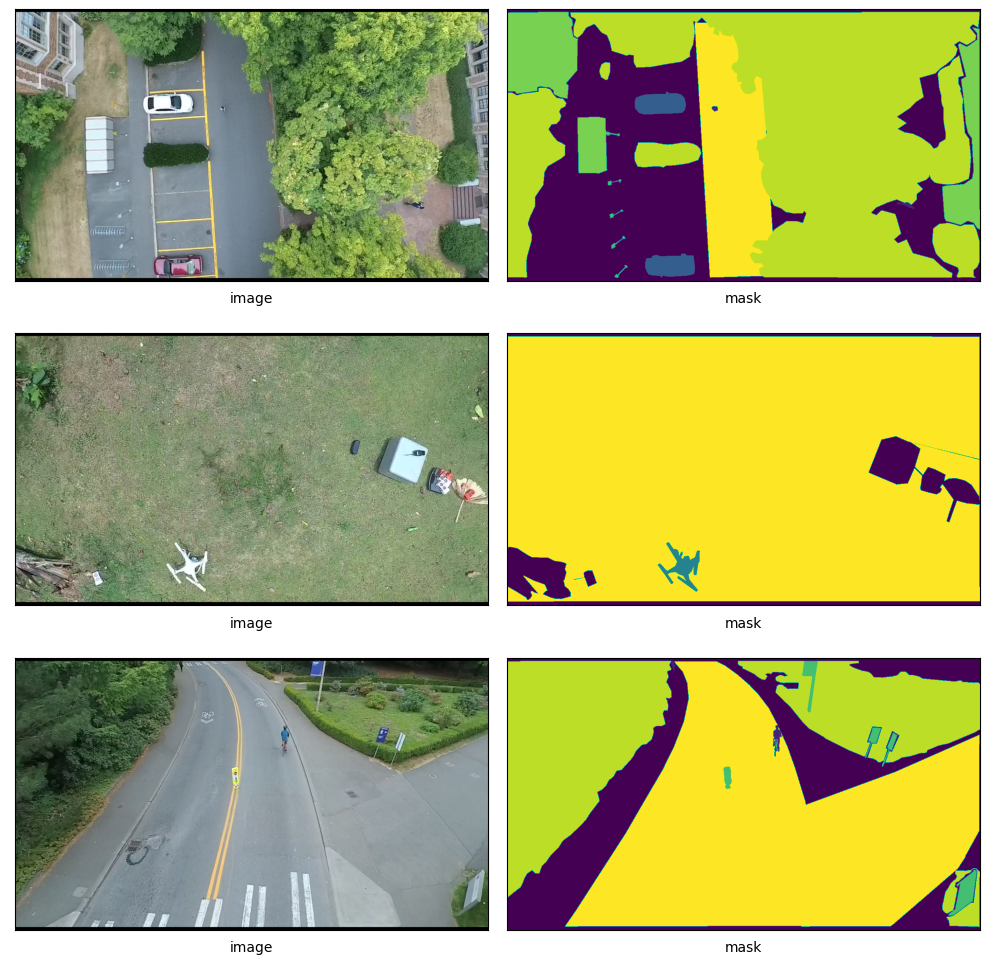

In [3]:
# show three examples of the training dataset and ground truth masks

train_dataset = SemSegDataset(data_path = OUTPUT_FOLDERS['train_data_path'], 
                              images_folder = OUTPUT_SUBFOLDERS['output_image_path'], 
                              masks_folder = OUTPUT_SUBFOLDERS['output_mask_path'],
                              num_classes = 11,
                              class_names = ['Background', 'Person', 'Bike', 'Car', 
                                             'Drone', 'Boat', 'Animal', 'Obstacle', 
                                             'Construction', 'Vegetation', 'Road', 'Sky']
                             )
draw_semantic_segmentation_samples(train_dataset, n_samples=3)

# <font style="color:green">2. Evaluation Metrics [10 Points]</font>

<p>This competition is evaluated on the mean <a href='https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient'>Dice coefficient</a
>. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by: </p>

<p>$$DSC =  \frac{2 |X \cap Y|}{|X|+ |Y|}$$
$$ \small \mathrm{where}\ X = Predicted\ Set\ of\ Pixels,\ \ Y = Ground\ Truth $$ </p>
<p>The Dice coefficient is defined to be 1 when both X and Y are empty.</p>

**In this section, you have to implement the dice coefficient evaluation metric.**

# <font style="color:green">3. Model [10 Points]</font>

**In this section, you have to define your model.**

In [ ]:
# model is defined in classes within 'segmentation' package to keep notebook manageable

# <font style="color:green">4. Train & Inference</font>

- **In this section, you have to train the model and infer on sample data.**


- **You can write your trainer class in this section.**


- **If you are using any loss function other than PyTorch standard loss function, you have to define in this section.**


- **This section should also have optimizer and LR-schedular (if using) details.**

## <font style="color:green">4.1. Train [7 Points]</font>

**Write your training code in this sub-section.**


**This section must contain training plots (use matplotlib or share tensorboard.dev scalars logs).**

**You must have to plot the following:**
- **train loss**


- **validation loss**


- **IoU for all twelve classes (0-11) and the mean IoU of all classes on validatin data.** 

**an example of matplotlib plot:**

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-train-loss.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-val-loss.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-mean_iou.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-iou-0.png'>

---

<center>*</center>
<center>*</center>
<center>*</center>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-iou-11.png'>

---

In [3]:
# 50 epochs wasn't enough, so i ran this cell a few times, but the results were only plotted for one of the earlier runs
# eventually i ran the next cell down for a final 25 epochs with a lower LR to get over the line for this project

# run the experiment for 50 epochs and learning rate of 0.001
EPOCHS = 50
BATCH_SIZE = 4

dataloader_config, trainer_config = patch_configs(epoch_num_to_set=EPOCHS, batch_size_to_set=BATCH_SIZE)

optimizer_config = OptimizerConfig(learning_rate=1e-3, lr_step_milestones =[], weight_decay=4e-5)

# existing_model=True means load the last checkpoint and continue training it
experiment = Experiment(train_data_path=OUTPUT_FOLDERS['train_data_path'], 
                        val_data_path=OUTPUT_FOLDERS['validation_data_path'], 
                        image_dir=OUTPUT_SUBFOLDERS['output_image_path'], 
                        mask_dir=OUTPUT_SUBFOLDERS['output_mask_path'],
                        dataloader_config=dataloader_config, 
                        optimizer_config=optimizer_config,
                        existing_model=True)

metrics = experiment.run(trainer_config)

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

In [3]:
# run the experiment with lower LR of 0.0001 for a final 25 epochs to get the required performance for this project

EPOCHS = 25
BATCH_SIZE = 4

dataloader_config, trainer_config = patch_configs(epoch_num_to_set=EPOCHS, batch_size_to_set=BATCH_SIZE)

optimizer_config = OptimizerConfig(learning_rate=1e-4, lr_step_milestones =[], weight_decay=4e-5)

experiment = Experiment(train_data_path=OUTPUT_FOLDERS['train_data_path'], 
                        val_data_path=OUTPUT_FOLDERS['validation_data_path'], 
                        image_dir=OUTPUT_SUBFOLDERS['output_image_path'], 
                        mask_dir=OUTPUT_SUBFOLDERS['output_mask_path'],
                        dataloader_config=dataloader_config, 
                        optimizer_config=optimizer_config,
                        existing_model=True)

metrics = experiment.run(trainer_config)

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

In [4]:
def plot_metrics(num_classes, metrics):
    plt.rcParams['figure.figsize'] = (20,15)
    plt.style.use('ggplot')
    plt.figure()
    num_cols = 3
    num_rows = math.ceil(num_classes/num_cols)

    ious = {}
    for i in range(num_classes):
        ious["test_iou_"+str(i)]=[]

    for metric_iou in metrics['test_metric']:
        for idx, iou in enumerate(metric_iou['iou']):
            ious["test_iou_"+str(idx)].append(iou)
    
    for id, (iou_cls, iou) in enumerate(ious.items()):
        plt.subplot(num_rows, num_cols, id+1)
        plt.plot(metrics['epoch'], iou, label='train_loss')
        
        plt.xlabel('Epochs')
        plt.ylabel(iou_cls)

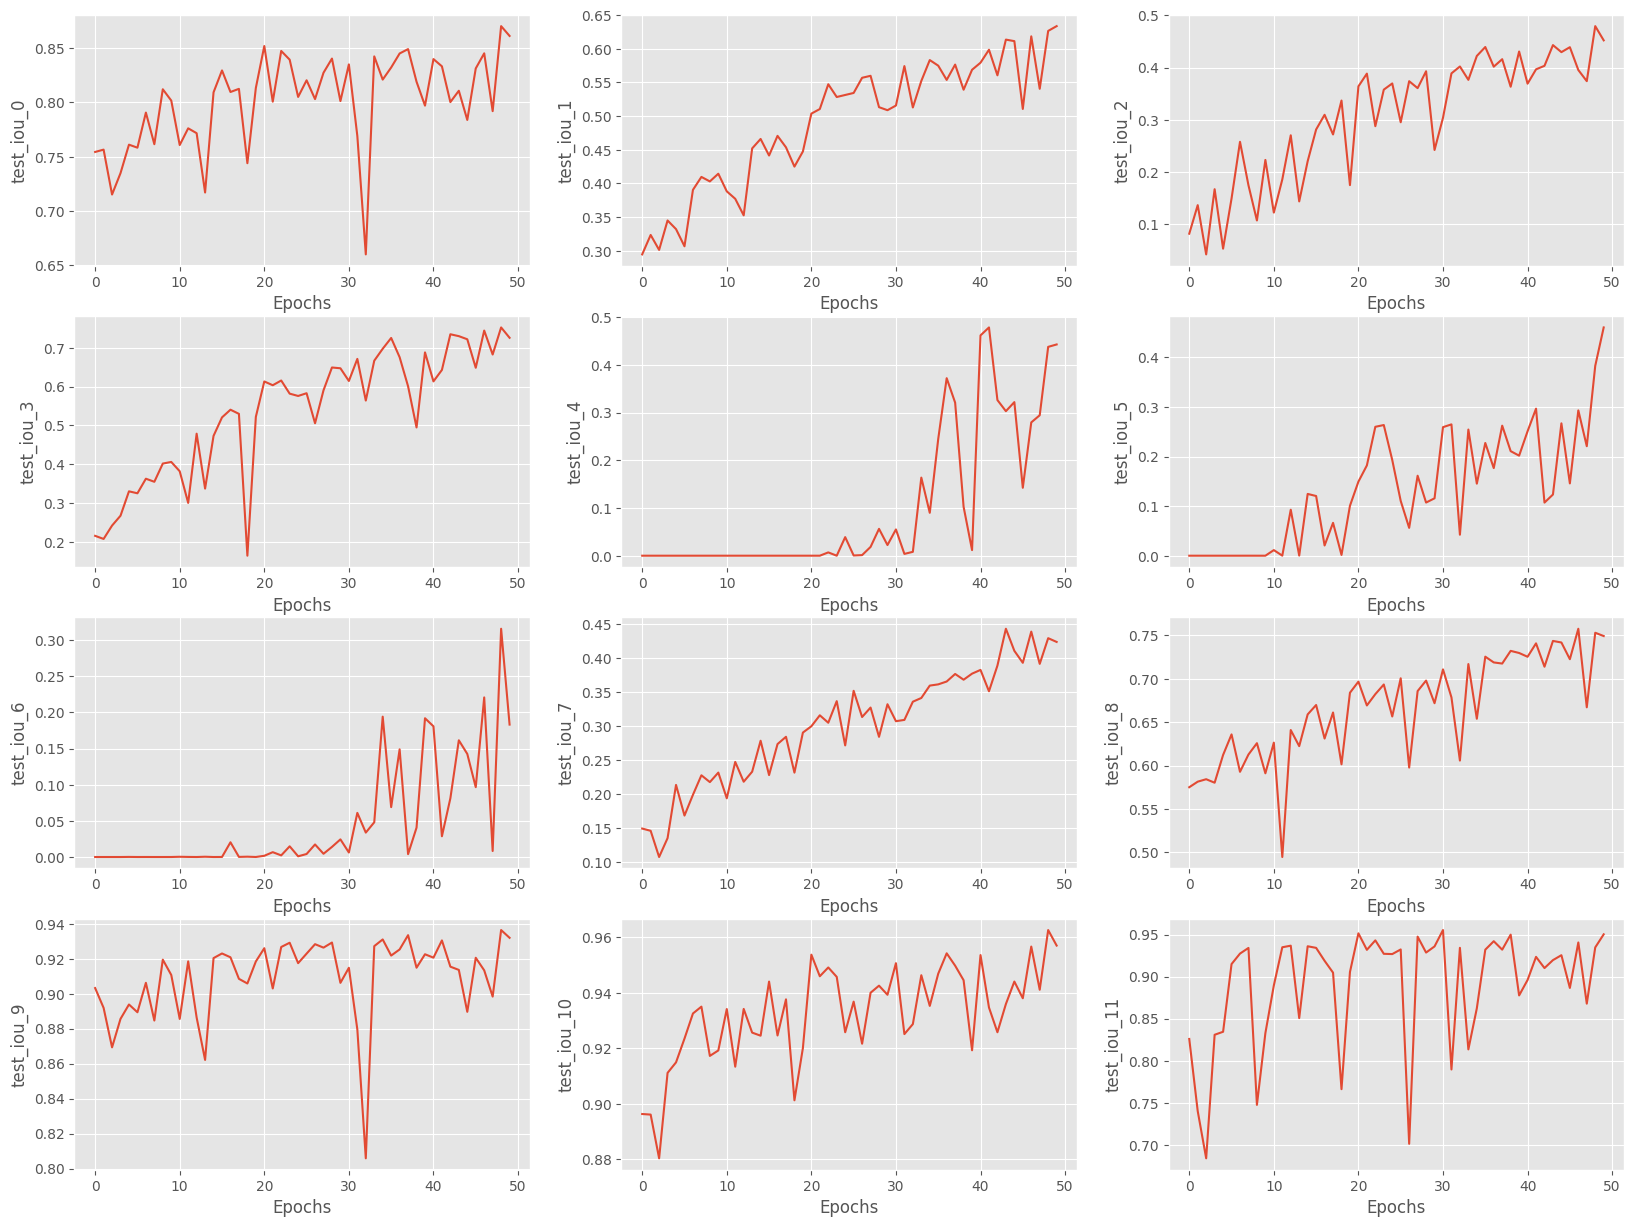

In [5]:
plot_metrics(experiment.loader_test.dataset.get_num_classes(), metrics)

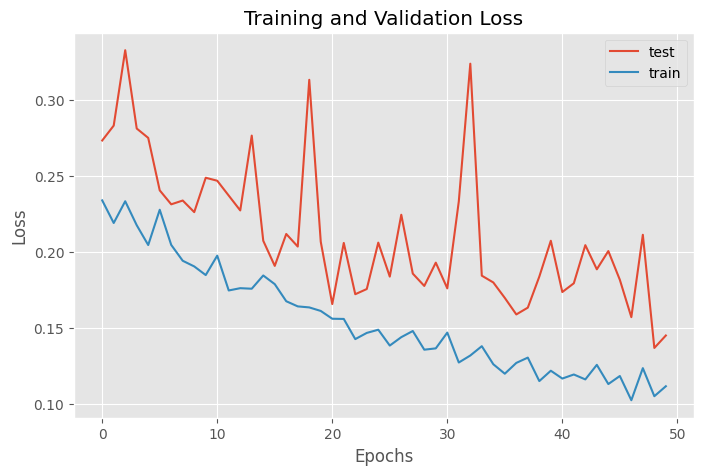

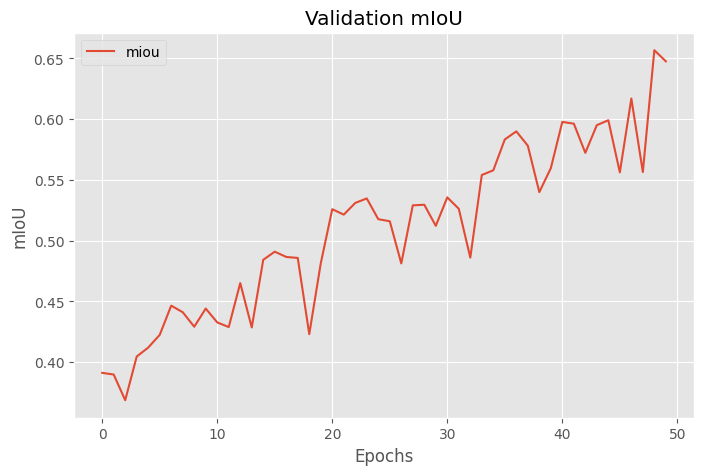

In [6]:
# Plot loss values and mIoU
# these are only plotted for the first 50 epochs.
# I had to run for several more epochs to get the required model performance
# ideally i would have foreseen this and logged the values to enable the results to be easily concatenated

plt.rcParams['figure.figsize'] = (8,5)
plt.style.use('ggplot')

# create new figure
plt.figure()
# plot test and train loss
plt.plot(metrics["test_loss"], label="test")
plt.plot(metrics["train_loss"], label="train")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# create new figure
plt.figure()
# plot mean iou metric for all classes
plt.plot([metric['mean_iou'] for metric in metrics["test_metric"]], label="miou")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('mIoU')
plt.title('Validation mIoU')

# # create new figure
# plt.figure()
# # plot learning rate
# plt.plot(metrics['learning_rate'], label="learning_rate")
# plt.legend()
# plt.xlabel('Epochs')
# plt.ylabel('lr')
# plt.title('Learning rate')

plt.show()

## <font style="color:green">4.2. Inference [3 Points]</font>

**Plot some sample inference in this sub-section.**

**for example:**

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-sample-predtiction.png'>

---

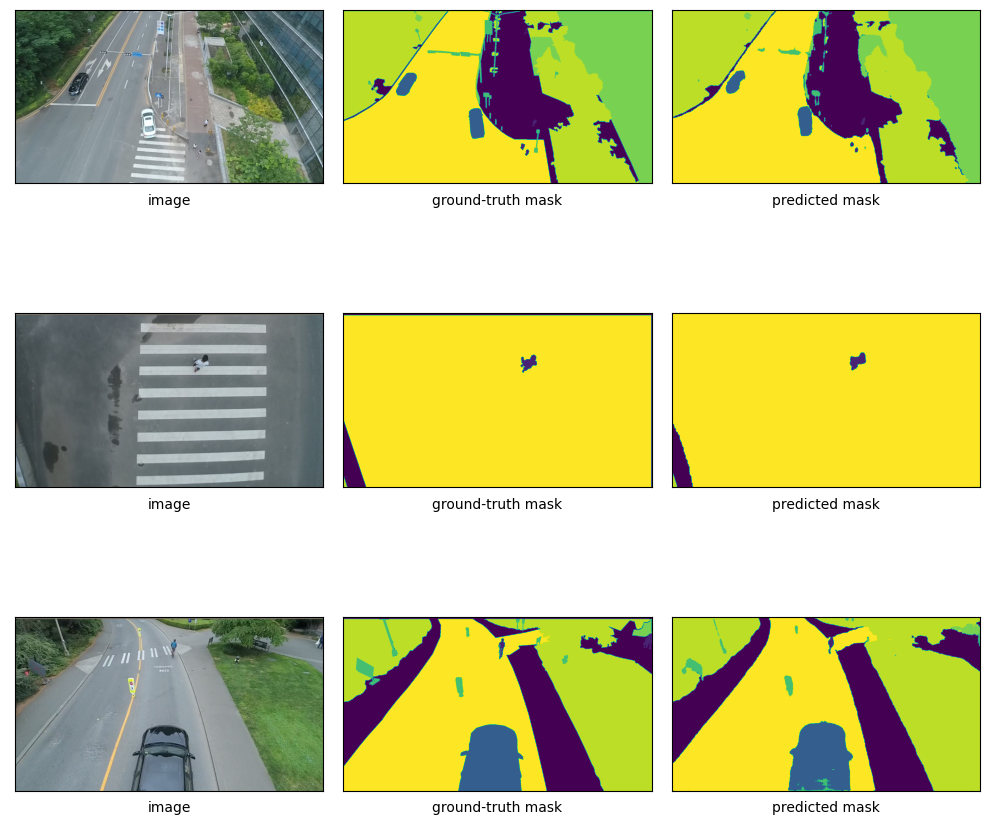

In [5]:
# get test samples
sample = next(iter(experiment.loader_test))
# get device to run the training on
device = torch.device(trainer_config.device)
# put images on the chosen device
images = sample["image"].to(device)

# get predictions and remove padding
preds = experiment.model(images).softmax(dim=1).argmax(dim=1)[:,8:728,:]
# visualize the results

mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32).to(device)
std  = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32).to(device)
mean = mean[None, :, None, None]
std  = std[None, :, None, None]
images = images * std + mean

draw_semantic_segmentation_batch(images, sample["mask"], preds)

# <font style="color:green">5. Prepare Submission CSV [10 Points]</font>

**Write your code to prepare the submission CSV file.**


**Note that in the submission file, you have to write Encoded Pixels.**

[Here is a blog to understand what is Encoded Pixels.](https://medium.com/analytics-vidhya/generating-masks-from-encoded-pixels-semantic-segmentation-18635e834ad0)

In [6]:
# takes a flattened mask image with n classes and returns a list of list of encoded pixels, one list for each class
# this function is fast but not 100% accurate as it does not include the first and last pixels of the mask
# but it's close enough for this application
def get_mask_encoded_pixels_2(flat_mask, num_classes):
    rle_list = [[]] * num_classes
    for c in range(num_classes):
        pixels = (flat_mask==c).long()        
        pixels[0] = 0
        pixels[-1] = 0
        rle_list[c] = torch.where(pixels[1:] != pixels[:-1])[0] + 1
        rle_list[c][1::2] = rle_list[c][1::2] - rle_list[c][:-1:2]
    return rle_list

In [7]:
# define test dataloader
# set inference_only=True so does not attempt to load ground truth masks

kaggle_test_loader = DataLoader(
    SemSegDataset(data_path = OUTPUT_FOLDERS["test_data_path"],
                  images_folder = OUTPUT_SUBFOLDERS["output_image_path"],
                  masks_folder = "",
                  num_classes = 12,
                  class_names = ['Background', 'Person', 'Bike', 'Car',
                                 'Drone', 'Boat', 'Animal', 'Obstacle',
                                 'Construction', 'Vegetation', 'Road', 'Sky'],
                  transforms=Compose([Normalize(), ToTensorV2()]),
                  inference_only=True),            
    batch_size=4,
    shuffle=False,
    num_workers=1,
    pin_memory=True
)

# make segmentation predictions for all inputs in dataset and add to a dictionary
# remember that images have been padded to allow passing through the LInknet architecture
# predictions need to be cropped to remove padding
# it's just 8 pixels from left and right in this case which i have hard coded here

all_preds = {}

for _, sample in tqdm.tqdm(enumerate(kaggle_test_loader)):
    images = sample["image"].to(device)
    preds = experiment.model(images).softmax(dim=1).argmax(dim=1)[:,8:728,:]
    for i, filename in enumerate(sample["file"]):
        all_preds[filename] = preds[i]



162it [00:29,  5.42it/s]


In [9]:
# encode predictions and export to csv for submission

num_classes = 12
rle = {}

with open('my_submission.csv', 'w', newline='') as csvfile:
    sub_writer = csv.writer(csvfile)
    sub_writer.writerow(['ImageID','EncodedPixels'])
    for pred in tqdm.tqdm(all_preds):
        filename, _ = os.path.splitext(os.path.basename(pred))
        rle[filename] = get_mask_encoded_pixels_2(torch.flatten(all_preds[pred]), num_classes)
        for c in range(num_classes):
            encoded_pixels = " ".join(str(x) for x in rle[filename][c].tolist())
            sub_writer.writerow([filename + "_" + str(c), encoded_pixels])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:07<00:00, 86.15it/s]


# <font style="color:green">6. Kaggle Profile Link [50 Points]</font>

Share your Kaggle profile link here with us so that we can give points for the competition score. 

You should have a minimum IoU of `0.60` on the test data to get all points. If the IoU is less than `0.55`, you will not get any points for the section. 

**You must have to submit `submission.csv` (prediction for images in `test.csv`) in `Submit Predictions` tab in Kaggle to get any evaluation in this section.**

## My Kaggle profile link:

https://www.kaggle.com/epipolarity/competitions?tab=active